<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/Titanic_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.EDA

In [415]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #model_selection doesn't need mentioning, only the method does
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score #given metric was accuracy


In [416]:
from google.colab import drive #Korean Army banned me from using os resources so I learned new ways
drive.mount('/content/gdrive')
titanic_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_train.csv') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##1)Basic Statistics

In [417]:
titanic_df.head(3) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [418]:
titanic_df.info() #objects are strings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [419]:
titanic_feature=titanic_df.drop(['Survived'], axis=1) #parameter axis is mandatory
titanic_label=titanic_df['Survived']

#2.Preprocessing

##1)Dropping&Creating features

In [420]:
titanic_feature['Family']=titanic_feature['SibSp']+titanic_feature['Parch']
titanic_feature=titanic_feature.drop(['PassengerId', 'Name','SibSp', 'Parch', 'Ticket'], axis=1) #drop method doesn't allow inplacing(Should check results along the way)

##2)Padding

In [421]:
titanic_feature['Age'].fillna(titanic_feature['Age'].mean(), inplace=True) #could be affecting, so average would minimize the loss(for further development, something could be inferred from sibsp&parch)
titanic_feature['Cabin'].fillna('N', inplace=True) #inplacing so that additional object would be unnecesory
titanic_feature['Embarked'].fillna('N',inplace=True) #Wonder features like this would be better off set random...
print(titanic_feature.isnull().sum().sum()) #checking

0


##3)Encoding

In [422]:
for feature in ['Sex', 'Cabin', 'Embarked']:
  print(titanic_feature[feature].value_counts(sort=True)) #focusing on columns

male      577
female    314
Name: Sex, dtype: int64
N              687
G6               4
B96 B98          4
C23 C25 C27      4
C22 C26          3
              ... 
E63              1
C118             1
A31              1
C82              1
B69              1
Name: Cabin, Length: 148, dtype: int64
S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [423]:
titanic_feature['Cabin']=titanic_df['Cabin'].str[:1] #Cabin needs insight that only the first character contains information #pd.str is applicable to series
features=['Cabin','Sex','Embarked']
for feature in features:
  titanic_feature[feature]=LabelEncoder().fit_transform(titanic_feature[feature].astype(str)) #changing dtype of series

##4)Scaling&Outliers(with Visualization)

1. Distribution
2. Correlation
3. Impacts on target

In [424]:
titanic_feature.head(3)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,22.0,7.2500,8,3,1
1,1,0,38.0,71.2833,2,0,1
2,3,0,26.0,7.9250,8,3,0


In [425]:
def count_plot(dataframe, feature, hue=None):
  f,ax=plt.subplots(figsize=(10,5))
  sns.countplot(data=dataframe, x=feature, hue=hue)
  plt.show()
def dist_plot(dataframe, feature):
  f,ax=plt.subplots(figsize=(10,5))
  sns.displot(data=dataframe, x=feature) #there is no 't'
  plt.show()

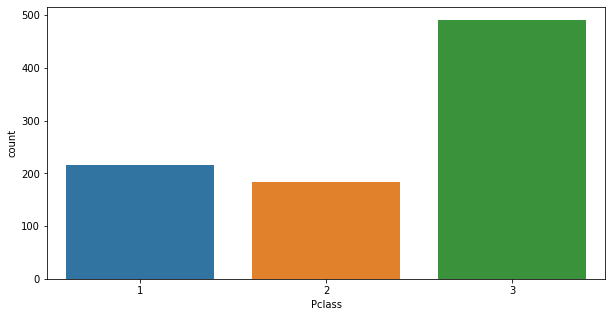

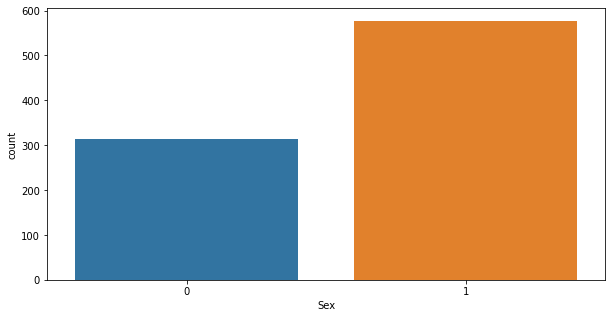

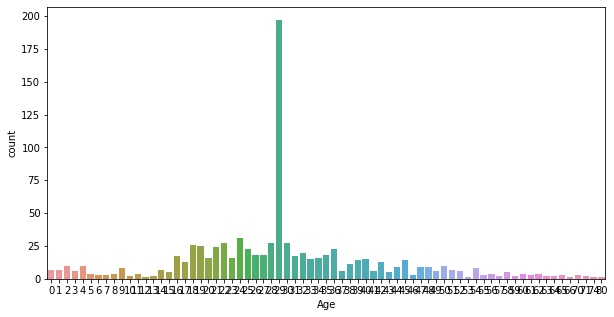

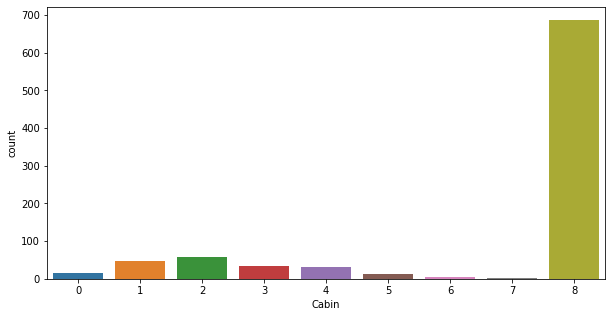

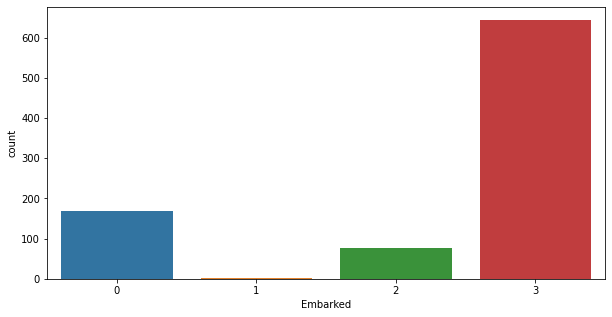

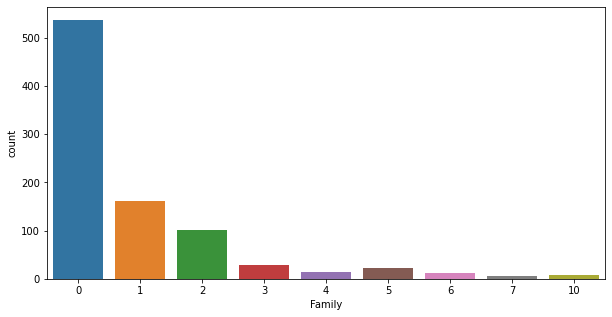

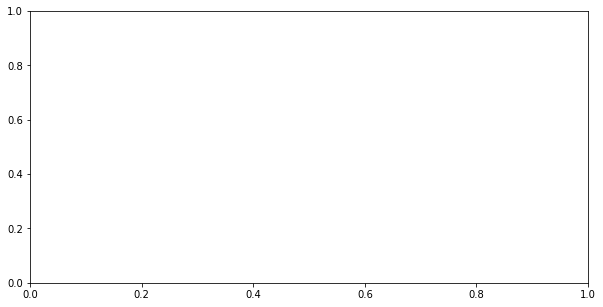

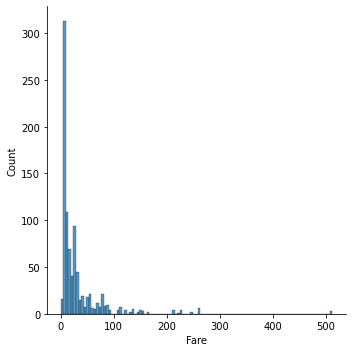

In [426]:
titanic_feature['Age']=titanic_feature['Age'].astype(int)
features_int=titanic_feature.columns.drop('Fare').values #columns is dataframe, so make it into ndarray
features_float='Fare'
for feature in features_int:
  count_plot(titanic_feature, feature)
dist_plot(titanic_feature, features_float)

In [427]:
for feature in ['Age', 'Cabin', 'Embarked','Fare','Family']:
  print(titanic_feature[feature].value_counts(sort=True)) #Sort by frequency

29    197
24     31
22     27
30     27
28     27
     ... 
74      1
66      1
12      1
53      1
80      1
Name: Age, Length: 71, dtype: int64
8    687
2     59
1     47
3     33
4     32
0     15
5     13
6      4
7      1
Name: Cabin, dtype: int64
3    644
0    168
2     77
1      2
Name: Embarked, dtype: int64
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64


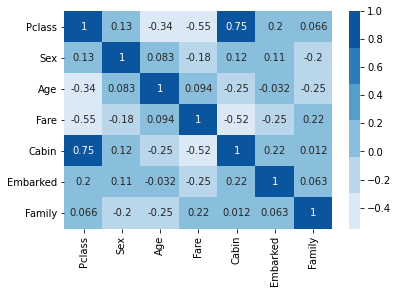

In [428]:
cmap=sns.color_palette('Blues') #I don't know each color
sns.heatmap(titanic_feature.corr(), annot=True, cmap=cmap) #annotatiion is a must
#classification rarely needs scaling

In [429]:
titanic_feature['Age'].replace(29,10)

0      22
1      38
2      26
3      35
4      35
       ..
886    27
887    19
888    10
889    26
890    32
Name: Age, Length: 891, dtype: int64

#3.CV&Tuning

In [430]:
rf_clf=RandomForestClassifier(random_state=0) #Cross validation need models 
xgb_clf=XGBClassifier(random_state=0)
lgbm_clf=LGBMClassifier(random_state=0)
X_train, X_test, y_train, y_test=train_test_split(titanic_feature, titanic_label, test_size=0.2,random_state=0)

In [431]:
rf_params={'n_estimators':[300],
           'max_depth':[6,8,10,12], #similar to decisiontree
           'min_samples_leaf':[3,5,7],
           'min_samples_split':[10,15,20]}
rf_gridcv=GridSearchCV(rf_clf, param_grid=rf_params, cv=5, n_jobs=-1) #using all CPU cores
rf_gridcv.fit(X_train, y_train)
print('best parameters:\n',rf_gridcv.best_params_)

best parameters:
 {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}


In [432]:
xgb_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[3,5,7],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
xgb_gridcv=GridSearchCV(xgb_clf, param_grid=xgb_params, cv=5, n_jobs=-1) 
xgb_gridcv.fit(X_train, y_train)
print('best parameters:\n',xgb_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


In [433]:
lgbm_params={'learning_rate' : [0.02], 
            'n_estimators':[200,300,400],
            'max_depth':[8,10,12],
            'num_leaves':[50],
            'colsample_bytree':[0.7,0.8],
            'subsample':[0.9]}
lgbm_gridcv=GridSearchCV(lgbm_clf, param_grid=lgbm_params, cv=5, n_jobs=-1) 
lgbm_gridcv.fit(X_train, y_train)
print('best parameters:\n',lgbm_gridcv.best_params_)

best parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.9}


#4.Modeling

In [434]:
rf_clf=rf_gridcv.best_estimator_
xgb_clf=xgb_gridcv.best_estimator_
lgbm_clf=lgbm_gridcv.best_estimator_
vo_clf=VotingClassifier(estimators=[('RandomForest',rf_clf),('XGBoost',xgb_clf),('LightGBM',lgbm_clf)], voting='soft')
vo_clf.fit(X_train, y_train)
pred1=rf_clf.fit(X_train, y_train).predict(X_test)
pred2=xgb_clf.fit(X_train, y_train).predict(X_test)
pred3=lgbm_clf.fit(X_train, y_train).predict(X_test)
pred4=vo_clf.predict(X_test)
print('Accuracy1:{0:.4f} Accuracy2:{1:.4f} Accuracy3:{2:4f}'.format(accuracy_score(y_test,pred1), accuracy_score(y_test,pred2),accuracy_score(y_test,pred3)))
print('Final accuracy:{0:.4f}'.format(accuracy_score(y_test,pred4))) #from python3.6 should use fstring formatting  #:separates index and the number

Accuracy1:0.8212 Accuracy2:0.8715 Accuracy3:0.837989
Final accuracy:0.8492


# 1)Uploading

In [435]:
from google.colab import drive 
drive.mount('/content/gdrive')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/titanic_test.csv') 
test_df.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [436]:
Pid=test_df['PassengerId']
test_df['Family']=test_df['SibSp']+test_df['Parch']
test_df=test_df.drop(['PassengerId','Name','SibSp', 'Parch', 'Ticket'], axis=1) #uploading needs the same preprocessing I did on training set(but no need to split feature&label) #Better off written in functions
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True) 
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True) 
test_df['Cabin'].fillna('N', inplace=True) 
test_df['Cabin']=test_df['Cabin'].str[:1] 
features=['Cabin','Sex','Embarked']
for feature in features:
  test_df[feature]=LabelEncoder().fit_transform(test_df[feature].astype(str))
test_df.head(3)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,3,1,34.5,7.8292,7,1,0
1,3,0,47.0,7.0000,7,2,1
2,2,1,62.0,9.6875,7,1,0


In [437]:
realpred=vo_clf.predict(test_df) #output of classifier is ndarray object
realpred=pd.DataFrame(realpred, columns=['Survived']) #never forget[]
Submit=pd.DataFrame({'PassengerId':Pid,'Survived':realpred['Survived']}) #Data set by giving each column name and data
Submit.head(3)
Submit.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_titanic.csv', index = False) #The client doesn't want indice on submission

# 2)Feedback<br>


#3)Afterwords
4.2.'21 I might be a genius 